In [28]:
import ares
import numpy as np
import matplotlib.pyplot as pl
import distpy


In [29]:
# Independent variables
redshifts = np.array([3, 3.8, 4, 4.9, 5, 5.9, 6, 6.9, 7, 7.9, 8])
MUV = np.arange(-28, -8.8, 0.2)
Mh = np.logspace(7, 13, 61)

# blob 1: the LF. Give it a name, and the function needed to calculate it.
blob_n1 = ['galaxy_lf']
blob_i1 = [('z', redshifts), ('x', MUV)]
blob_f1 = ['LuminosityFunction']

# blob 2: the SFE. Same deal.
blob_n2 = ['fstar']
blob_i2 = [('z', redshifts), ('Mh', Mh)]
blob_f2 = ['fstar']

In [30]:
blob_pars = \
{
 'blob_names': [blob_n1, blob_n2],
 'blob_ivars': [blob_i1, blob_i2],
 'blob_funcs': [blob_f1, blob_f2],
 'blob_kwargs': [None] * 2,
}

In [31]:
base_pars = ares.util.ParameterBundle('mirocha2017:base').pars_by_pop(0, True)
base_pars.update(blob_pars)

# This is important!
base_pars['pop_calib_lum'] = None

In [50]:
free_pars = \
  [
   'pq_func_par0[0]',
   'pq_func_par1[0]',
   'pq_func_par2[0]',
   'pq_func_par3[0]',
  ]
#which pars belong to what?

is_log = [True, True, False, False]

from distpy.distribution import UniformDistribution
from distpy.distribution import DistributionSet, BernoulliDistribution

ps = DistributionSet()
ps.add_distribution(UniformDistribution(-3, 0.), 'pq_func_par0[0]')
ps.add_distribution(UniformDistribution(9, 13),  'pq_func_par1[0]')
ps.add_distribution(UniformDistribution(0, 2),   'pq_func_par2[0]')
ps.add_distribution(UniformDistribution(-2, 0),  'pq_func_par3[0]')

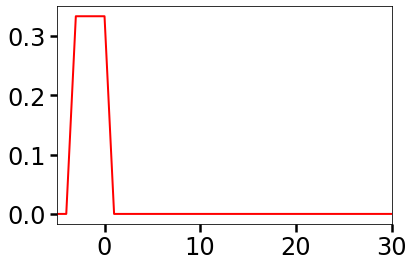

In [63]:
distribution = UniformDistribution(-3, 0)

(start, end) = (-5, 30)
xs = np.linspace(start, end, end - start + 1).astype(int)

fig = pl.figure()
ax = fig.add_subplot(111)
distribution.plot(xs, ax=ax, show=False, linewidth=2, color='r')
# ax.set_xlim((-0.5, 1.5))

In [33]:
guesses = \
{
 'pq_func_par0[0]': -1,
 'pq_func_par1[0]': 11.5,
 'pq_func_par2[0]': 0.5,
 'pq_func_par3[0]': -0.5,
}

In [41]:
# Initialize a fitter object and give it the data to be fit
fitter_lf = ares.inference.FitGalaxyPopulation(**base_pars)

# The data can also be provided more explicitly
# fitter_lf.data = 'bouwens2015'

In [42]:
fitter = ares.inference.ModelFit(**base_pars)
fitter.add_fitter(fitter_lf)

# Establish the object to which we'll pass parameters
from ares.populations.GalaxyCohort import GalaxyCohort
fitter.simulator = GalaxyCohort

In [43]:
fitter.save_hmf = True  # cache HMF for a speed-up!
fitter.save_psm = True  # cache source SED model (e.g., BPASS, S99)

# Setting this flag to False will make ARES generate new files for each checkpoint.
# 2-D blobs can get large, so this allows us to just download a single
# snapshot or two if we'd like (useful if running on remote machine)
fitter.checkpoint_append = False

fitter.parameters = free_pars
fitter.is_log = is_log
fitter.prior_set = ps

# In general, the more the merrier (~hundreds)
fitter.nwalkers = 16

fitter.jitter = [0.1] * len(fitter.parameters)
fitter.guesses = guesses

# Run the thing
fitter.run('test_lfcal', burn=0, steps=10, save_freq=1, clobber=True)

Saved HaloMassFunction instance to limit I/O.
# Starting MCMC: Tue Jun 16 11:58:23 2020
emcee: Exception while calling your likelihood function:
  params: [-1.14488421 11.54765925  0.46410914 -0.54375256]
  args: ['test_lfcal', ['pq_func_par0[0]', 'pq_func_par1[0]', 'pq_func_par2[0]', 'pq_func_par3[0]'], [True, True, False, False], <distpy.distribution.DistributionSet.DistributionSet object at 0x000001BFC36ABC88>, <distpy.distribution.DistributionSet.DistributionSet object at 0x000001BFC36B6C88>, [array([[[inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        ...,
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf]]]), array([[[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
         inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
         inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
    

Traceback (most recent call last):
  File "C:\Users\Emma\Anaconda3\lib\site-packages\emcee\ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "C:\Users\Emma\Anaconda3\lib\site-packages\ares-0.1-py3.7.egg\ares\inference\ModelFit.py", line 216, in loglikelihood
    lnL += fitter.loglikelihood(sim)
  File "C:\Users\Emma\Anaconda3\lib\site-packages\ares-0.1-py3.7.egg\ares\inference\FitGalaxyPopulation.py", line 281, in loglikelihood
    self._loglikelihood = loglikelihood(self.xdata_flat,
  File "C:\Users\Emma\Anaconda3\lib\site-packages\ares-0.1-py3.7.egg\ares\inference\FitGalaxyPopulation.py", line 497, in xdata_flat
    for i, dataset in enumerate(self.data[quantity]):
  File "C:\Users\Emma\Anaconda3\lib\site-packages\ares-0.1-py3.7.egg\ares\inference\FitGalaxyPopulation.py", line 360, in data
    raise AttributeError('Must set data by hand!')
AttributeError: Must set data by hand!


AttributeError: Must set data by hand!

In [22]:
anl = ares.analysis.ModelSet('test_lfcal')


##############################################################################################################
####                                         Analysis: Model Set                                          ####
##############################################################################################################
#### ---------------------------------------------------------------------------------------------------- ####
#### Basic Information                                                                                    ####
#### ---------------------------------------------------------------------------------------------------- ####
#### path        : ./                                                                                     ####
#### prefix      : test_lfcal                                                                             ####
#### N-d         : 4                                                                                      ####


UnboundLocalError: local variable '_chain' referenced before assignment

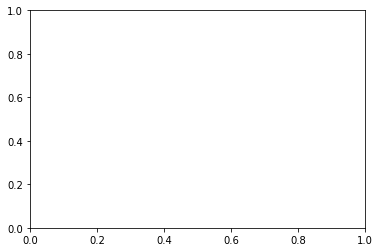

In [23]:
ax = anl.ReconstructedFunction('galaxy_lf', ivar=[6, None], samples='all', color='b', alpha=0.01)

ax.set_yscale('log')